In [1]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.png' or ext == '.jpg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [15]:
metadata = load_metadata('/home/osman/PycharmProjects/DjangoProjects/FRS/media/aligned_images')

In [30]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# OpenCV loads images with color channels
# in BGR order. So we need to reverse them
# transform BGR to RGB color channel

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('/home/osman/Downloads/shape_predictor_68_face_landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    # Load an image
    original = load_image(metadata[img_index].image_path())

    # Detect face and return bounding box
    bb = alignment.getLargestFaceBoundingBox(original)
    print("bb " + str(bb))

    # Transform image using specified face landmark indices and crop image to 96x96
    if bb is not None:
        aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    else:
        print("Cannot aligned")
    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    if bb is not None:
        plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    plt.subplot(133)
    plt.imshow(aligned)

bb [(12, 30) (167, 184)]


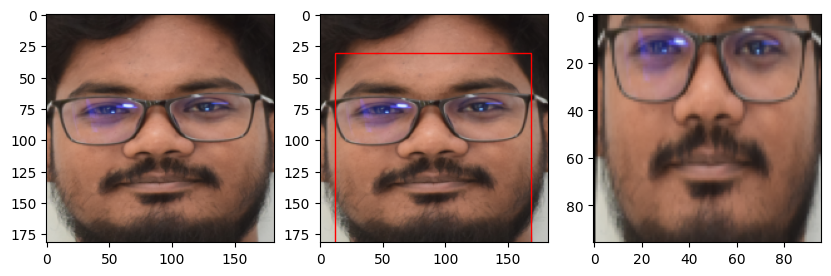

In [32]:
show_original_and_aligned(10)
# metadata.shape

In [33]:
#define for future use

def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)


In [34]:
class ImageClass():
    "Stores the paths to images for a given class"
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
  
    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'
  
    def __len__(self):
        return len(self.image_paths)
    
def get_dataset(path, has_class_directories=True):
    dataset = []
    path_exp = os.path.expanduser(path)
    classes = [path for path in os.listdir(path_exp) \
                    if os.path.isdir(os.path.join(path_exp, path))]
    
    print("Classes Before sorting: "+ str(classes))
    classes.sort()
    print("Classes After sorting: "+ str(classes))
    
    nrof_classes = len(classes)
    for i in range(nrof_classes):
        class_name = classes[i]
        facedir = os.path.join(path_exp, class_name)
        image_paths = get_image_paths(facedir)
        dataset.append(ImageClass(class_name, image_paths))
  
    return dataset

def get_image_paths(facedir):
    image_paths = []
    if os.path.isdir(facedir):
        images = os.listdir(facedir)
        image_paths = [os.path.join(facedir,img) for img in images]
    return image_paths

def get_image_paths_and_labels(dataset):
    image_paths_flat = []
    labels_flat = []
    for i in range(len(dataset)):
        image_paths_flat += dataset[i].image_paths
        labels_flat += [i] * len(dataset[i].image_paths)
    return image_paths_flat, labels_flat

def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        # img = misc.imread(image_paths[i])
        img = imageio.imread(image_paths[i], pilmode='RGB').astype(np.float)
        # print(images[i], img.ndim)
        if img.ndim == 2:
            img = to_rgb(img)
        if do_prewhiten:
            img = prewhiten(img)
        img = crop(img, do_random_crop, image_size)
        img = flip(img, do_random_flip)
        images[i,:,:,:] = img
    return images

def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y  

def crop(image, random_crop, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        if random_crop:
            diff = sz1-sz2
            (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
        else:
            (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image
  
def flip(image, random_flip):
    if random_flip and np.random.choice([True, False]):
        image = np.fliplr(image)
    return image

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret

In [81]:
import os, re, imageio
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def load_model(model, input_map=None):
    # Check if the model is a model directory (containing a metagraph and a checkpoint file)
    #  or if it is a protobuf file with a frozen graph
    model_exp = os.path.expanduser(model)
    if (os.path.isfile(model_exp)):
        print('Model filename: %s' % model_exp)
        with gfile.FastGFile(model_exp,'rb') as f:
            graph_def = tf.compat.v1.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, input_map=input_map, name='')
    else:
        print('Model directory: %s' % model_exp)
        meta_file, ckpt_file = get_model_filenames(model_exp)
        
        print('Metagraph file: %s' % meta_file)
        print('Checkpoint file: %s' % ckpt_file)
        with tf.compat.v1.Session() as sess:
            
            train_set = get_dataset('/home/osman/PycharmProjects/DjangoProjects/FRS/media/aligned_images')
            image_list, label_list = get_image_paths_and_labels(train_set)
            
            # print("image list ", image_list)
            # print("label list ", label_list)
            # return
            nrof_images = len(image_list)
            
            
            saver = tf.compat.v1.train.import_meta_graph(os.path.join(model_exp, meta_file), input_map=input_map)
            saver.restore(tf.compat.v1.get_default_session(), os.path.join(model_exp, ckpt_file))
            
            images_placeholder = tf.compat.v1.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.compat.v1.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.compat.v1.get_default_graph().get_tensor_by_name("phase_train:0")
            
            embedding_size = embeddings.get_shape()[1]
            print("Number of images" + str(nrof_images))
            print("Embedding size" + str(embedding_size))
            print("images_placeholder" + str(images_placeholder))
            print("phase_train_placeholder" + str(phase_train_placeholder))
            
            emb_array = np.zeros((nrof_images, embedding_size))
            
            images = load_data(image_list[:], False, False, 160)
            
            print("*********************** images after loading ***********************")
            # print(images)
            # return
            feed_dict = { images_placeholder: images, phase_train_placeholder:False }
                # Use the facenet model to calcualte embeddings
            embed = sess.run(embeddings, feed_dict=feed_dict)
            
        return embed
    
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    ckpt = tf.train.get_checkpoint_state(model_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_file = os.path.basename(ckpt.model_checkpoint_path)
        return meta_file, ckpt_file

    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file


In [82]:

# Path to the directory containing the saved model files
model_path = '/home/osman/PycharmProjects/ComputerVision/facenet_TF_2/ConvertedToTf2/models/TripletLoss/FromPretrained/Epoch_481'
model_path = '/home/osman/PycharmProjects/ComputerVision/facenet_TF_2/ConvertedToTf2/models/BestAccuracy'

# Load the model

# Path to the directory containing the checkpoint files
checkpoint_dir = '/home/osman/PycharmProjects/ComputerVision/facenet_TF_2/ConvertedToTf2/models/TripletLoss/FromPretrained/Epoch_481'
checkpoint_dir = '/home/osman/PycharmProjects/ComputerVision/facenet_TF_2/ConvertedToTf2/models/BestAccuracy'


embed = load_model(model_path)

print("******************** Embedding Array ********************")
print(embed)


Model directory: /home/osman/PycharmProjects/ComputerVision/facenet_TF_2/ConvertedToTf2/models/BestAccuracy
Metagraph file: model-20230716-175325.meta
Checkpoint file: model-20230716-175325.ckpt-272
INFO:tensorflow:Restoring parameters from /home/osman/PycharmProjects/ComputerVision/facenet_TF_2/ConvertedToTf2/models/BestAccuracy/model-20230716-175325.ckpt-272
Number of images70
Embedding size512
images_placeholderTensor("input:0", shape=(None, 160, 160, 3), dtype=float32)
phase_train_placeholderTensor("phase_train:0", dtype=bool)
*********************** images after loading ***********************
******************** Embedding Array ********************
[[-0.03596326 -0.0698554  -0.02627017 ... -0.01936676  0.01015145
   0.00604536]
 [-0.05522319 -0.06887612 -0.0437623  ... -0.00619145 -0.02044861
  -0.01776981]
 [-0.07186168 -0.07197193 -0.03924039 ... -0.00762282 -0.01051794
  -0.01522513]
 ...
 [-0.01794368 -0.01448443 -0.07930075 ...  0.03846054 -0.0030394
  -0.05126996]
 [-0.034

In [62]:
print(embed.shape)

(70, 512)


In [38]:
print(embed[0].shape)

(512,)


In [63]:
import math

def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),0)
        # print("Diff" + str(diff.shape))
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=0)
        norm = np.linalg.norm(embeddings1, axis=0) * np.linalg.norm(embeddings2, axis=0)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric 
        
    return dist

def show_pair(idx1, idx2, dist_met):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embed[idx1], embed[idx2], dist_met):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

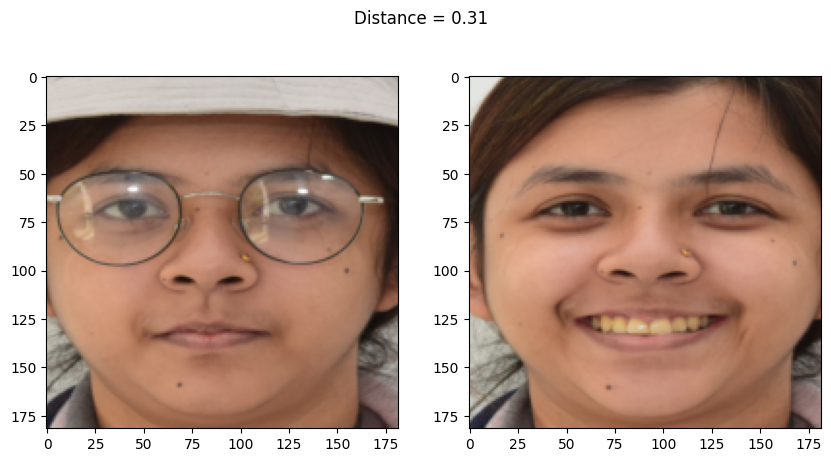

In [64]:
show_pair(65, 60, 0)

num  70
Thresholds  [0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85
 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
Len:  (70,)


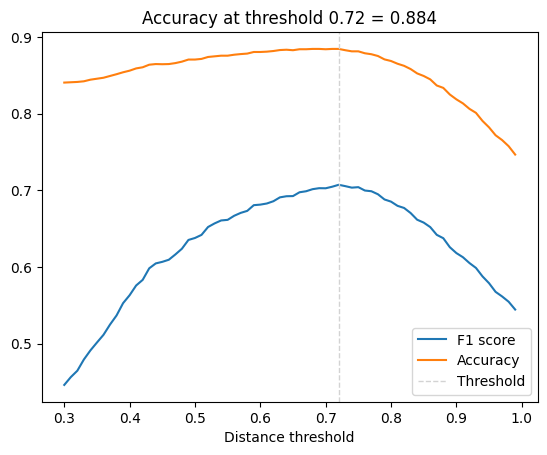

In [86]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)
print("num ", num)
# print("metadata ", metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embed[i], embed[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

# print("distances ", distances.shape)
# print("identical ", identical.shape)

thresholds = np.arange(0.3, 1.0, 0.01)

print("Thresholds ", thresholds)
print("Len: ", thresholds.shape)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

# print("f1 scores ", f1_scores)
# print("acc_scores ", acc_scores)

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

dist_pos 971
dist_neg 3790


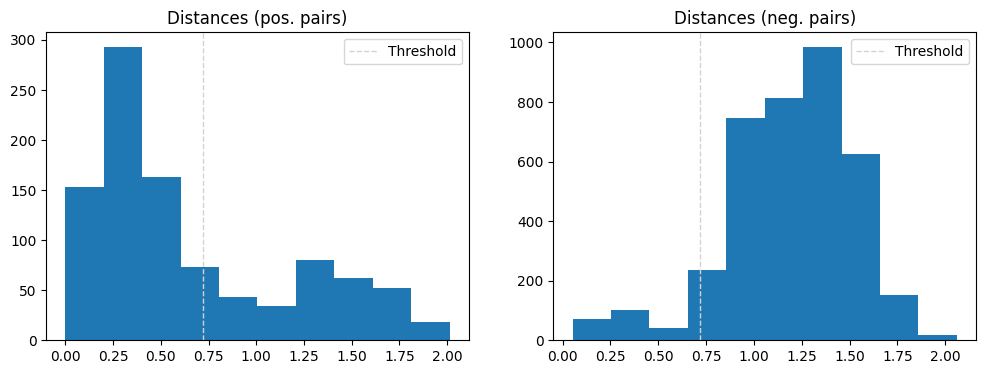

In [88]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

print("dist_pos", len(dist_pos))
print("dist_neg", len(dist_neg))

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

# print("Targets", targets)

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

# print("y ", y)

test_idx = np.arange(metadata.shape[0]) % 2 != 0
train_idx = np.arange(metadata.shape[0]) % 2 == 0

# print("Test idx", test_idx)
# print("Train_idx", train_idx)
# 50 train examples of 10 identities (5 examples each)
X_train = embed[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embed[test_idx]

# print("X_train ", X_train)
# print("X_test ", X_test)

y_train = y[train_idx]
y_test = y[test_idx]

# print("y_train ", y_train)
# print("y_test ", y_test)

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = knn.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.8285714285714286, SVM accuracy = 0.8285714285714286


In [68]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = knn.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata[test_idx][idx].image_path())
        example_prediction = knn.predict([embed[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');        

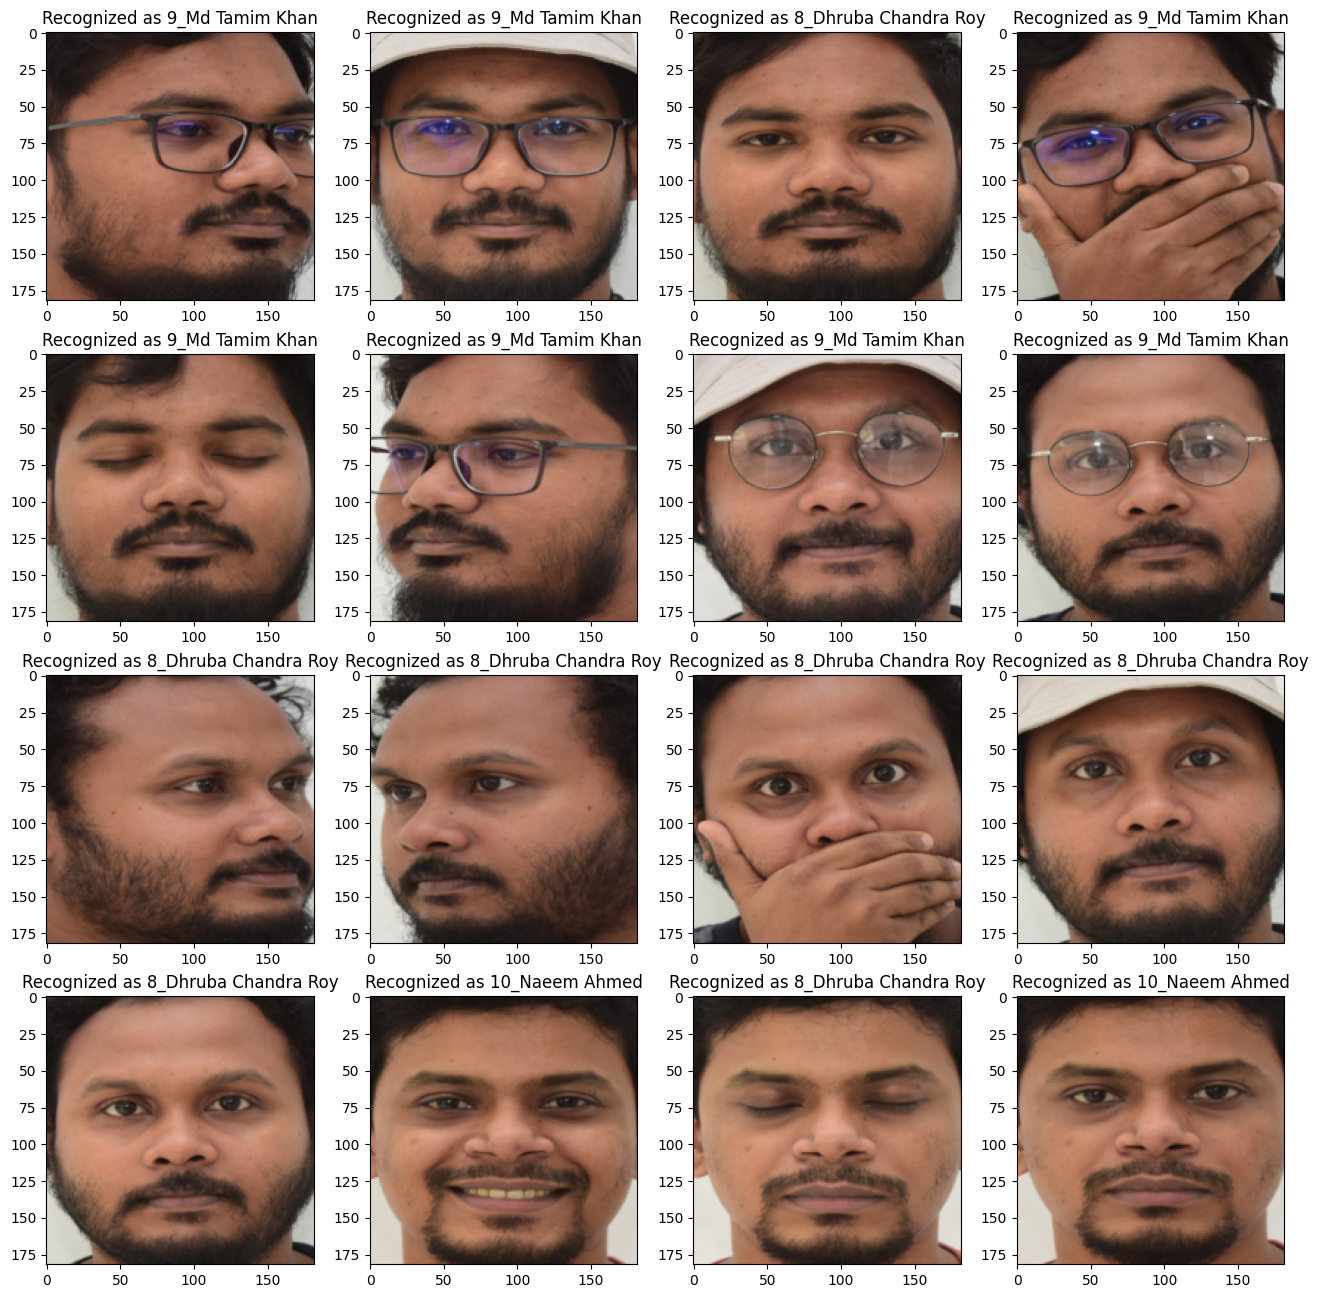

In [69]:
show_predictions(range(0, 70))

[2, 6, 7, 14, 21, 28]


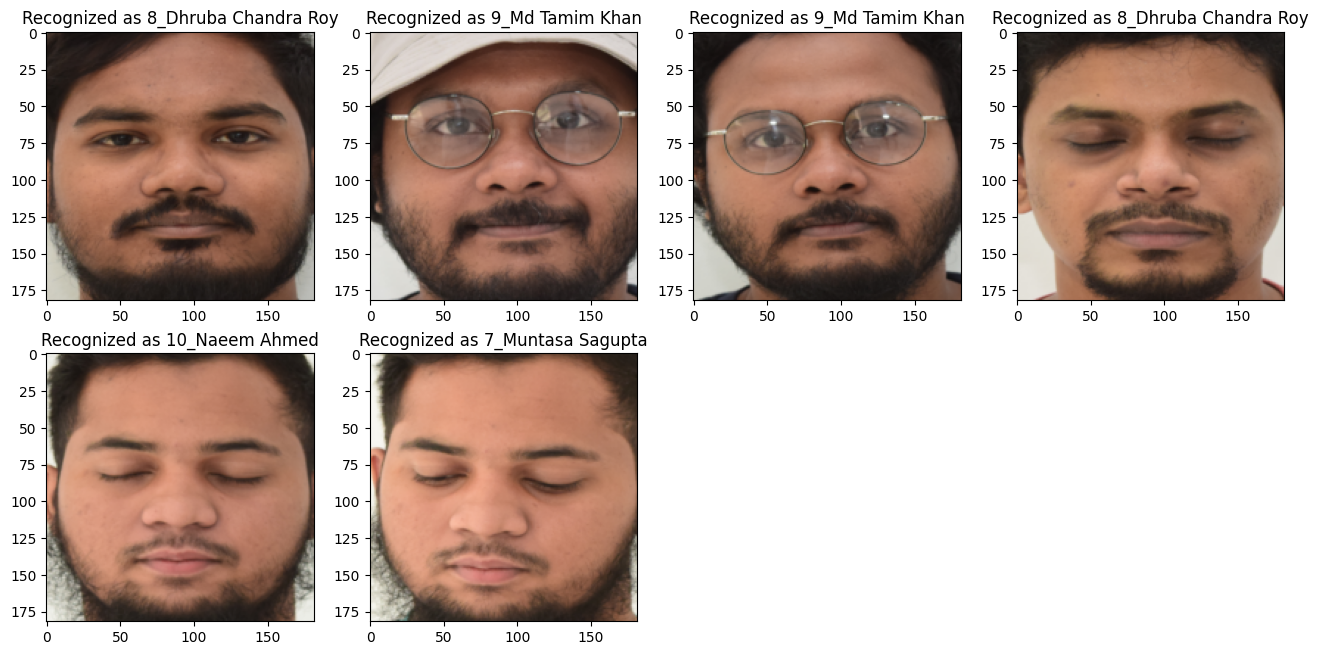

In [70]:
error_pairs = []

for i, item in enumerate(y_pred_svc):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)

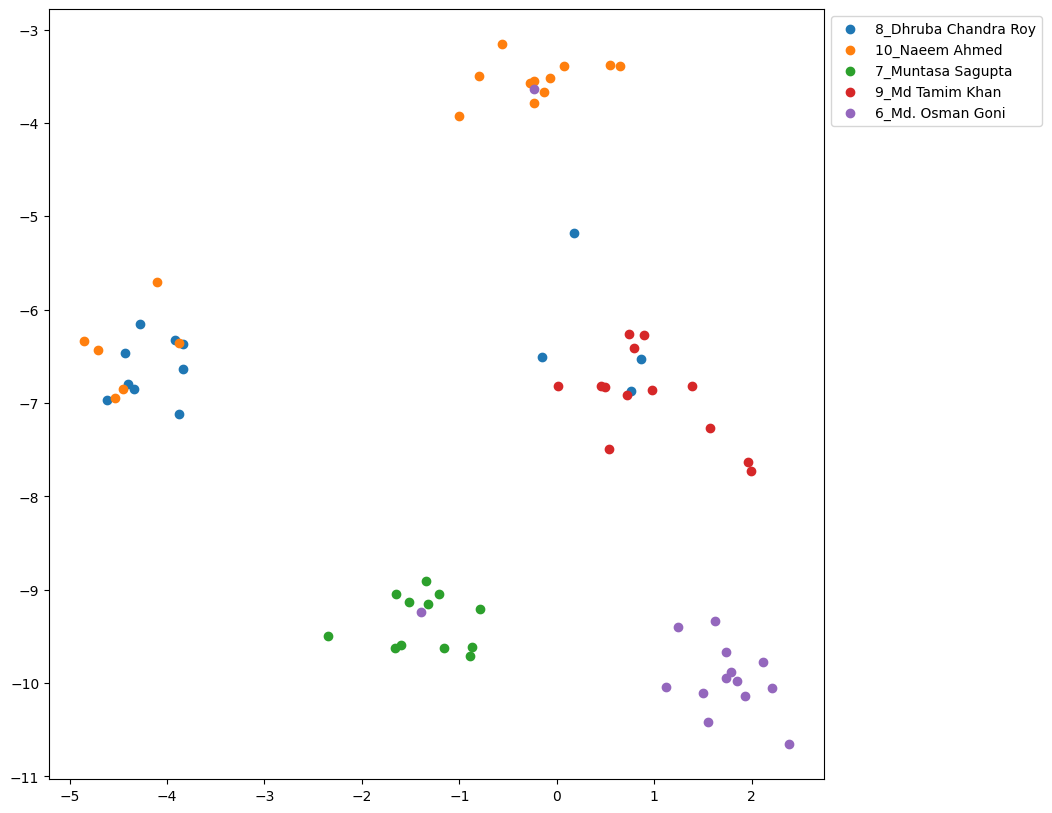

In [71]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embed)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));